#### CHALLENGES
HR analytics is revolutionising the way human resources departments operate, leading to higher efficiency and better results overall. Human resources have been using analytics for years, however, the collection, processing, and analysis of data has been largely manual. Given the nature of human resources dynamics and HR KPIs, the approach has been constraining HR. Therefore, it is surprising that HR departments wokeup to the utility of machine learning so late in the game. Data analysts can derive insights from the data, and predictive analytics can be done by data scientists and engineers

#### PROJECT DESCRIPTION: HR ANALYTICS CLASSIFICATION
Here is an opportunity to try predictive analytics in identifying the employees most likely to get promoted.Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problemsyour client is facing is identifying the right people for promotion (only for manager positions and below) and preparing them in time. The process they currently
follow is to:
First, identify a set of employees based on recommendations/ past performance, then selected employees go through the separate training and evaluation program for each vertical, and these programs are based on the required skill of each vertical.
At the end of the program, based on various factors such as training performance, KPI completion, the employee gets a promotion. But only employees with KPIs completed greater than 60% are usually considered.
For the aforementioned process, the final promotions are only announced after the evaluation, and this leads to delay in the transition to their new roles. Hence, the company needs assistance in identifying the eligible candidates at a particular checkpoint, so that they can expedite the entire promotion cycle.
They have provided multiple attributes around the employee's past and current performance along with demographics. Now, the task is to predict whether a potential “promotee” at the checkpoint in the test set will be promoted or not, after the evaluation process.

<h2>Import All Libraries</h2>

In [1]:
#import all libraries and classes
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier
from imblearn.under_sampling import  RandomUnderSampler
from collections import Counter
from imblearn.under_sampling import NeighbourhoodCleaningRule
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle
matplotlib.style.use("ggplot")
sns.set()

C:\Users\Williams\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import And Inspect The Dataset

In [2]:
#import the dataset
trainset= pd.read_csv(r"train_LZdllcl.csv")
testset = pd.read_csv(r"test_2umaH9m.csv")

# Exploratory Data Analysis (EDA)

## Data Info

In [3]:
#inspect the first five records
trainset.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.00,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.00,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.00,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.00,2,0,0,73,0


In [4]:
#inspect the dimension of the dataset
trainset.shape

(54808, 14)

In [5]:
#inspect the data types of each column of the dataset
trainset.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [6]:
#inspect some quick statistics of the dataset
trainset.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.00,54808.00,54808.00,50684.00,54808.00,54808.00,54808.00,54808.00,54808.00
mean,39195.83,1.25,34.80,3.33,5.87,0.35,0.02,63.39,0.09
std,22586.58,0.61,7.66,1.26,4.27,0.48,0.15,13.37,0.28
min,1.00,1.00,20.00,1.00,1.00,0.00,0.00,39.00,0.00
25%,19669.75,1.00,29.00,3.00,3.00,0.00,0.00,51.00,0.00
50%,39225.50,1.00,33.00,3.00,5.00,0.00,0.00,60.00,0.00
75%,58730.50,1.00,39.00,4.00,7.00,1.00,0.00,76.00,0.00
max,78298.00,10.00,60.00,5.00,37.00,1.00,1.00,99.00,1.00


<h2>Data Preparation And Wrangling</h2>

## Wrangling the trainset

In [7]:
#copy the dataset to another variable just to keep the original dataset
trainset_copy = trainset.copy()

In [8]:
#rename the KPI column
trainset_copy.rename(columns={"KPIs_met >80%": "KPIs_met >60%"}, inplace=True)

In [9]:
#check for null columns
trainset_copy.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >60%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [10]:
#check the data types of the null columns
print(trainset_copy["education"].dtypes)
print(trainset_copy["previous_year_rating"].dtypes)

object
float64


### Cleaning the "education" column

In [11]:
#check the frequency of each education qualification
trainset_copy["education"].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [12]:
#inspect the first 5 observations containing null values in the "education" column
trainset_copy[trainset_copy["education"].isnull()].head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,NaN,m,sourcing,1,30,nan,1,0,0,77,0
21,33332,Operations,region_15,NaN,m,sourcing,1,41,4.00,11,0,0,57,0
32,35465,Sales & Marketing,region_7,NaN,f,sourcing,1,24,1.00,2,0,0,48,0
43,17423,Sales & Marketing,region_2,NaN,m,other,3,24,2.00,2,0,0,48,0
82,66013,Sales & Marketing,region_2,NaN,m,sourcing,2,25,3.00,2,0,0,53,0


In [13]:
#check the frequency of each category of the "department" column
trainset_copy["department"].value_counts()

Sales & Marketing    16840
Operations           11348
Procurement           7138
Technology            7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [14]:
#inspect the sum of null values in education
trainset_copy["education"].isnull().sum()

2409

In [15]:
#check the frequency of the class of Education for all Sales & Marketing personnel
trainset_copy.groupby("department").get_group("Sales & Marketing")["education"].value_counts()

Bachelor's          11099
Master's & above     4166
Name: education, dtype: int64

In [16]:
#check the number of values of "education" qualification that is in the "Sales & Marketing" department
trainset_copy.groupby("department").get_group("Sales & Marketing")["education"].isnull().sum()

1575

In [17]:
#calculate and store the proportion of each "education" qualification that is in the "Sales & Marketing" department
b = int(11099/(11099+4166)*1575)
m = 1575 - b

In [18]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Sales & Marketing")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [19]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Sales & Marketing")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [20]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("Sales & Marketing")["education"].isnull().sum()

0

In [21]:
#check the frequency of the class of Education for all Operations personneltrainset_copy
trainset_copy.groupby("department").get_group("Operations")["education"].value_counts()

Bachelor's          7781
Master's & above    3165
Below Secondary      176
Name: education, dtype: int64

In [22]:
#check the number of values of "education" qualification that is in the "Operations" department
trainset_copy.groupby("department").get_group("Operations")["education"].isnull().sum()

226

In [23]:
#calculate and store the proportion of each "education" qualification that is in the "Operations" department
b = int(7781/(7781+3165+176)*226)
m = int(3165/(7781+3165+176)*226)
s = 226 - b - m

In [24]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Operations")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [25]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Operations")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [26]:
#fill a proportion of null fields with "Below Secondary"
S = trainset_copy.groupby("department").get_group("Operations")["education"].fillna(value="Below Secondary", limit=s)
trainset_copy["education"].update(S)

In [27]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("Operations")["education"].isnull().sum()

0

In [28]:
#check the frequency of the class of Education for all Procurement personnel
trainset_copy.groupby("department").get_group("Procurement")["education"].value_counts()

Bachelor's          4393
Master's & above    2544
Below Secondary      129
Name: education, dtype: int64

In [29]:
#check the number of values of "education" qualification that is in the "Procurement" department
trainset_copy.groupby("department").get_group("Procurement")["education"].isnull().sum()

72

In [30]:
#calculate and store the proportion of each "education" qualification that is in the "Procurement" department
b = int(4393/(4393+2544+129)*72)
m = int(2544/(4393+2544+129)*72)
s = 72 - b - m

In [31]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Procurement")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [32]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Procurement")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [33]:
#fill a proportion of null fields with "Below Secondary"
S = trainset_copy.groupby("department").get_group("Procurement")["education"].fillna(value="Below Secondary", limit=s)
trainset_copy["education"].update(S)

In [34]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("Procurement")["education"].isnull().sum()

0

In [35]:
#check the frequency of the class of Education for all Technology personnel
trainset_copy.groupby("department").get_group("Technology")["education"].value_counts()

Bachelor's          4642
Master's & above    2196
Below Secondary      201
Name: education, dtype: int64

In [36]:
#check the number of values of "education" qualification that is in the "Technology" department
trainset_copy.groupby("department").get_group("Technology")["education"].isnull().sum()

99

In [37]:
#calculate and store the proportion of each "education" qualification that is in the "Technology" department
b = int(4642/(4642+2196+201)*99)
m = int(2196/(4642+2196+201)*99)
s = 99 - b - m

In [38]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Technology")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [39]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Technology")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [40]:
#fill a proportion of null fields with "Below Secondary"
S = trainset_copy.groupby("department").get_group("Technology")["education"].fillna(value="Below Secondary", limit=s)
trainset_copy["education"].update(S)

In [41]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("Technology")["education"].isnull().sum()

0

In [42]:
#check the frequency of the class of Education for all Analytics personnel
trainset_copy.groupby("department").get_group("Analytics")["education"].value_counts()

Bachelor's          3978
Master's & above    1037
Name: education, dtype: int64

In [43]:
#check the number of values of "education" qualification that is in the "Analytics" department
trainset_copy.groupby("department").get_group("Analytics")["education"].isnull().sum()

337

In [44]:
#calculate and store the proportion of each "education" qualification that is in the "Analytics" department
b = int(3978/(3978+1037)*337)
m = 337 - b

In [45]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Analytics")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [46]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Analytics")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [47]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("Analytics")["education"].isnull().sum()

0

In [48]:
#check the frequency of the class of Education for all Finance personnel
trainset_copy.groupby("department").get_group("Finance")["education"].value_counts()

Bachelor's          1895
Master's & above     499
Below Secondary      106
Name: education, dtype: int64

In [49]:
#check the number of values of "education" qualification that is in the "Finance" department
trainset_copy.groupby("department").get_group("Finance")["education"].isnull().sum()

36

In [50]:
#calculate and store the proportion of each "education" qualification that is in the "Finance" department
b = int(1895/(1895+499+106)*36)
m = int(499/(1895+499+106)*36)
s = 36 - b - m

In [51]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Finance")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [52]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Finance")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [53]:
#fill a proportion of null fields with "Below Secondary"
S = trainset_copy.groupby("department").get_group("Finance")["education"].fillna(value="Below Secondary", limit=s)
trainset_copy["education"].update(S)

In [54]:
#confirm that it has been filledtrainset_copy
trainset_copy.groupby("department").get_group("Finance")["education"].isnull().sum()

0

In [55]:
#check the frequency of the class of Education for all HR personnel
trainset_copy.groupby("department").get_group("HR")["education"].value_counts()

Bachelor's          1525
Master's & above     733
Below Secondary      128
Name: education, dtype: int64

In [56]:
#check the number of values of "education" qualification that is in the "HR" department
trainset_copy.groupby("department").get_group("HR")["education"].isnull().sum()

32

In [57]:
#calculate and store the proportion of each "education" qualification that is in the "HR" department
b = int(1525/(1525+733+128)*32)
m = int(733/(1525+733+128)*32)
s = 32 - b - m

In [58]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("HR")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [59]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("HR")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [60]:
#fill a proportion of null fields with "Below Secondary"
S = trainset_copy.groupby("department").get_group("HR")["education"].fillna(value="Below Secondary", limit=s)
trainset_copy["education"].update(S)

In [61]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("HR")["education"].isnull().sum()

0

In [62]:
#check the frequency of the class of Education for all Legal personnel
trainset_copy.groupby("department").get_group("Legal")["education"].value_counts()

Bachelor's          814
Master's & above    156
Below Secondary      65
Name: education, dtype: int64

In [63]:
#check the number of values of "education" qualification that is in the "Legal" department
trainset_copy.groupby("department").get_group("Legal")["education"].isnull().sum()

4

In [64]:
#calculate and store the proportion of each "education" qualification that is in the "legal" department
b = 2
m = 1
s = 1

In [65]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("Legal")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [66]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("Legal")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [67]:
#fill a proportion of null fields with "Below Secondary"
S = trainset_copy.groupby("department").get_group("Legal")["education"].fillna(value="Below Secondary", limit=s)
trainset_copy["education"].update(S)

In [68]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("Legal")["education"].isnull().sum()

0

In [69]:
#check the frequency of the class of Education for all R&D personnel
trainset_copy.groupby("department").get_group("R&D")["education"].value_counts()

Bachelor's          542
Master's & above    429
Name: education, dtype: int64

In [70]:
#check the number of values of "education" qualification that is in the "R&D" department
trainset_copy.groupby("department").get_group("R&D")["education"].isnull().sum()

28

In [71]:
#calculate and store the proportion of each "education" qualification that is in the "R&D" department
b = int(542/(542+429)*28)
m = 28 - b

In [72]:
#fill a proportion of null fields with "Bachelor's"
B = trainset_copy.groupby("department").get_group("R&D")["education"].fillna(value="Bachelor's", limit=b)
trainset_copy["education"].update(B)

In [73]:
#fill a proportion of null fields with "Master's & above"
M = trainset_copy.groupby("department").get_group("R&D")["education"].fillna(value="Master's & above", limit=m)
trainset_copy["education"].update(M)

In [74]:
#confirm that it has been filled
trainset_copy.groupby("department").get_group("R&D")["education"].isnull().sum()

0

In [75]:
#inspect "education" column for missing values
trainset_copy["education"].isnull().sum()

0

### Cleaning the "previous_year_rating" column

In [76]:
#inspect the sum of null values in "previous_year_rating"
trainset_copy["previous_year_rating"].isnull().sum()

4124

In [77]:
#check the frequency of each education qualification
trainset_copy["previous_year_rating"].value_counts()

3.00    18618
5.00    11741
4.00     9877
1.00     6223
2.00     4225
Name: previous_year_rating, dtype: int64

In [78]:
#inspect the first 5 observations containing null values in the "education" column
trainset_copy[trainset_copy["previous_year_rating"].isnull()].head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,Bachelor's,m,sourcing,1,30,nan,1,0,0,77,0
23,71177,Procurement,region_5,Bachelor's,m,other,1,27,nan,1,0,0,70,0
29,74759,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,nan,1,0,0,44,0
56,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,nan,1,0,0,49,0
58,26599,Sales & Marketing,region_16,Bachelor's,m,other,2,27,nan,1,1,0,47,0


In [79]:
#inspect the full dataset
trainset_copy.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.00,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.00,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.00,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.00,2,0,0,73,0


In [80]:
#inspect the total number of null values in the "previous_year_rating" column
trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].isnull().sum()

4124

In [81]:
#inspect each available rating
trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].value_counts()

3.00    158
4.00    114
5.00     64
1.00     44
2.00     43
Name: previous_year_rating, dtype: int64

In [82]:
#calculate and store the proportion of each rating
one = int(44/(44+43+64+114+158)*4124)
two = int(43/(44+43+64+114+158)*4124)
three = int(64/(44+43+64+114+158)*4124)
four = int(114/(44+43+64+114+158)*4124)
five = 4124 - (one + two + three + four)

In [83]:
#fill a proportion of null fields with 1
ONE = trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=1, limit=one)
trainset_copy["previous_year_rating"].update(ONE)

In [84]:
#fill a proportion of null fields with 2
TWO = trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=2, limit=two)
trainset_copy["previous_year_rating"].update(TWO)

In [85]:
#fill a proportion of null fields with 3
THREE = trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=3, limit=three)
trainset_copy["previous_year_rating"].update(THREE)

In [86]:
#fill a proportion of null fields with 4
FOUR = trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=4, limit=four)
trainset_copy["previous_year_rating"].update(FOUR)

In [87]:
#fill a proportion of null fields with 5
FIVE =trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=5, limit=five)
trainset_copy["previous_year_rating"].update(FIVE)

In [88]:
#inspect the null values
trainset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].isnull().sum()

0

In [89]:
#confirm that the null values have been filled
trainset_copy["previous_year_rating"].isnull().sum()

0

In [90]:
#double check the whole dataset for any null valuestrainset_copy
trainset_copy.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >60%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

## Wrangling the testset

In [91]:
#copy the dataset to another variable just to keep the original dataset
testset_copy = testset.copy()

In [92]:
#rename the KPI column
testset_copy.rename(columns={"KPIs_met >80%": "KPIs_met >60%"}, inplace=True)

In [93]:
#check for null columns
testset_copy.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >60%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [94]:
#check the data types of the null columns
print(testset_copy["education"].dtypes)
print(testset_copy["previous_year_rating"].dtypes)

object
float64


### Cleaning the "education" column

In [95]:
#check the frequency of each education qualification
testset_copy["education"].value_counts()

Bachelor's          15578
Master's & above     6504
Below Secondary       374
Name: education, dtype: int64

In [96]:
#inspect the first 5 observations containing null values in the "education" column
testset_copy[testset_copy["education"].isnull()].head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score
49,3720,Sales & Marketing,region_2,NaN,m,sourcing,1,36,5.00,4,1,0,49
67,26977,Operations,region_2,NaN,m,sourcing,1,28,3.00,3,0,0,59
89,2347,Analytics,region_15,NaN,m,other,2,37,5.00,8,1,0,82
127,42719,Analytics,region_21,NaN,m,sourcing,1,27,nan,1,0,0,80
138,2721,Analytics,region_22,NaN,f,sourcing,2,26,5.00,3,1,0,86


In [97]:
#check the frequency of each category of the "department" column
testset_copy["department"].value_counts()

Sales & Marketing    7315
Operations           4764
Procurement          3020
Technology           3011
Analytics            2319
Finance              1091
HR                   1085
Legal                 445
R&D                   440
Name: department, dtype: int64

In [98]:
#inspect the sum of null values in education
testset_copy["education"].isnull().sum()

1034

In [99]:
#check the frequency of the class of Education for all Sales & Marketing personnel
testset_copy.groupby("department").get_group("Sales & Marketing")["education"].value_counts()

Bachelor's          4818
Master's & above    1834
Name: education, dtype: int64

In [100]:
#check the number of values of "education" qualification that is in the "Sales & Marketing" department
testset_copy.groupby("department").get_group("Sales & Marketing")["education"].isnull().sum()

663

In [101]:
#calculate and store the proportion of each "education" qualification that is in the "Sales & Marketing" department
b = int(4818/(4818+1834)*663)
m = 663 - b

In [102]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Sales & Marketing")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [103]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("Sales & Marketing")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [104]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Sales & Marketing")["education"].isnull().sum()

0

In [105]:
#check the frequency of the class of Education for all Operations personnel
testset_copy.groupby("department").get_group("Operations")["education"].value_counts()

Bachelor's          3298
Master's & above    1301
Below Secondary       73
Name: education, dtype: int64

In [106]:
#check the number of values of "education" qualification that is in the "Operations" department
testset_copy.groupby("department").get_group("Operations")["education"].isnull().sum()

92

In [107]:
#calculate and store the proportion of each "education" qualification that is in the "Operations" department
b = int(3298/(3298+1301+73)*92)
m = int(1301/(3298+1301+73)*92)
s = 92 - b - m

In [108]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Operations")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [109]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("Operations")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [110]:
#fill a proportion of null fields with "Below Secondary"
S = testset_copy.groupby("department").get_group("Operations")["education"].fillna(value="Below Secondary", limit=s)
testset_copy["education"].update(S)

In [111]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Operations")["education"].isnull().sum()

0

In [112]:
#check the frequency of the class of Education for all Procurement personnel
testset_copy.groupby("department").get_group("Procurement")["education"].value_counts()

Bachelor's          1807
Master's & above    1101
Below Secondary       72
Name: education, dtype: int64

In [113]:
#check the number of values of "education" qualification that is in the "Procurement" department
testset_copy.groupby("department").get_group("Procurement")["education"].isnull().sum()

40

In [114]:
#calculate and store the proportion of each "education" qualification that is in the "Procurement" department
b = int(1807/(1807+1101+72)*40)
m = int(1101/(1807+1101+72)*40)
s = 40 - b - m

In [115]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Procurement")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [116]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("Procurement")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [117]:
#fill a proportion of null fields with "Below Secondary"
S = testset_copy.groupby("department").get_group("Procurement")["education"].fillna(value="Below Secondary", limit=s)
testset_copy["education"].update(S)

In [118]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Procurement")["education"].isnull().sum()

0

In [119]:
#check the frequency of the class of Education for all Technology personnel
testset_copy.groupby("department").get_group("Technology")["education"].value_counts()

Bachelor's          1916
Master's & above     966
Below Secondary       87
Name: education, dtype: int64

In [120]:
#check the number of values of "education" qualification that is in the "Technology" department
testset_copy.groupby("department").get_group("Technology")["education"].isnull().sum()

42

In [121]:
#calculate and store the proportion of each "education" qualification that is in the "Technology" department
b = int(1916/(1916+966+87)*42)
m = int(966/(1916+966+87)*42)
s = 42 - b - m

In [122]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Technology")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [123]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("Technology")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [124]:
#fill a proportion of null fields with "Below Secondary"
S = testset_copy.groupby("department").get_group("Technology")["education"].fillna(value="Below Secondary", limit=s)
testset_copy["education"].update(S)

In [125]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Technology")["education"].isnull().sum()

0

In [126]:
#check the frequency of the class of Education for all Analytics personnel
testset_copy.groupby("department").get_group("Analytics")["education"].value_counts()

Bachelor's          1703
Master's & above     461
Name: education, dtype: int64

In [127]:
#check the number of values of "education" qualification that is in the "Analytics" department
testset_copy.groupby("department").get_group("Analytics")["education"].isnull().sum()

155

In [128]:
#calculate and store the proportion of each "education" qualification that is in the "Analytics" department
b = int(1703/(1703+461)*155)
m = 155 - b

In [129]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Analytics")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [130]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("Analytics")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [131]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Analytics")["education"].isnull().sum()

0

In [132]:
#check the frequency of the class of Education for all Finance personnel
testset_copy.groupby("department").get_group("Finance")["education"].value_counts()

Bachelor's          788
Master's & above    240
Below Secondary      49
Name: education, dtype: int64

In [133]:
#check the number of values of "education" qualification that is in the "Finance" department
testset_copy.groupby("department").get_group("Finance")["education"].isnull().sum()

14

In [134]:
#calculate and store the proportion of each "education" qualification that is in the "Finance" department
b = int(788/(788+240+49)*14)
m = int(240/(788+240+49)*14)
s = 14 - b - m

In [135]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Finance")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [136]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("Finance")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [137]:
#fill a proportion of null fields with "Below Secondary"
S = testset_copy.groupby("department").get_group("Finance")["education"].fillna(value="Below Secondary", limit=s)
testset_copy["education"].update(S)

In [138]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Finance")["education"].isnull().sum()

0

In [139]:
#check the frequency of the class of Education for all HR personnel
testset_copy.groupby("department").get_group("HR")["education"].value_counts()

Bachelor's          685
Master's & above    328
Below Secondary      58
Name: education, dtype: int64

In [140]:
#check the number of values of "education" qualification that is in the "HR" department
testset_copy.groupby("department").get_group("HR")["education"].isnull().sum()

14

In [141]:
#calculate and store the proportion of each "education" qualification that is in the "HR" department
b = int(685/(685+328+58)*14)
m = int(328/(685+328+58)*14)
s = 14 - b - m

In [142]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("HR")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [143]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("HR")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [144]:
#fill a proportion of null fields with "Below Secondary"
S = testset_copy.groupby("department").get_group("HR")["education"].fillna(value="Below Secondary", limit=s)
testset_copy["education"].update(S)

In [145]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("HR")["education"].isnull().sum()

0

In [146]:
#check the frequency of the class of Education for all Legal personnel
testset_copy.groupby("department").get_group("Legal")["education"].value_counts()

Bachelor's          336
Master's & above     72
Below Secondary      35
Name: education, dtype: int64

In [147]:
#check the number of values of "education" qualification that is in the "Legal" department
testset_copy.groupby("department").get_group("Legal")["education"].isnull().sum()

2

In [148]:
#calculate and store the proportion of each "education" qualification that is in the "legal" department
b = 1
s = 1

In [149]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("Legal")["education"].fillna(value="Bachelor's", limit=1)
testset_copy["education"].update(B)

In [150]:
#fill a proportion of null fields with "Below Secondary"
S = testset_copy.groupby("department").get_group("Legal")["education"].fillna(value="Below Secondary")
testset_copy["education"].update(S)

In [151]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("Legal")["education"].isnull().sum()

0

In [152]:
#check the frequency of the class of Education for all R&D personnel
testset_copy.groupby("department").get_group("R&D")["education"].value_counts()

Bachelor's          227
Master's & above    201
Name: education, dtype: int64

In [153]:
#check the number of values of "education" qualification that is in the "R&D" department
testset_copy.groupby("department").get_group("R&D")["education"].isnull().sum()

12

In [154]:
#calculate and store the proportion of each "education" qualification that is in the "R&D" department
b = int(227/(227+201)*12)
m = 12 - b

In [155]:
#fill a proportion of null fields with "Bachelor's"
B = testset_copy.groupby("department").get_group("R&D")["education"].fillna(value="Bachelor's", limit=b)
testset_copy["education"].update(B)

In [156]:
#fill a proportion of null fields with "Master's & above"
M = testset_copy.groupby("department").get_group("R&D")["education"].fillna(value="Master's & above", limit=m)
testset_copy["education"].update(M)

In [157]:
#confirm that it has been filled
testset_copy.groupby("department").get_group("R&D")["education"].isnull().sum()

0

In [158]:
#inspect "education" column for missing values
testset_copy["education"].isnull().sum()

0

### Cleaning the "previous_year_rating" column

In [159]:
#inspect the sum of null values in "previous_year_rating"
testset_copy["previous_year_rating"].isnull().sum()

1812

In [160]:
#check the frequency of each education qualification
testset_copy["previous_year_rating"].value_counts()

3.00    7921
5.00    5097
4.00    4249
1.00    2680
2.00    1731
Name: previous_year_rating, dtype: int64

In [161]:
#inspect the first 5 observations containing null values in the "education" column
testset_copy[testset_copy["previous_year_rating"].isnull()].head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,nan,1,1,0,77
21,5677,Technology,region_17,Bachelor's,m,sourcing,1,25,nan,1,0,0,80
32,67672,Technology,region_17,Bachelor's,m,other,1,29,nan,1,1,0,85
39,55325,Analytics,region_22,Bachelor's,m,other,1,25,nan,1,0,0,88
47,44159,Analytics,region_22,Master's & above,m,other,1,31,nan,1,1,0,84


In [162]:
#inspect the full dataset
testset_copy.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,nan,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.00,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.00,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.00,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.00,7,0,0,61


In [163]:
#inspect the total number of null values in the "previous_year_rating" column
testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].isnull().sum()

1812

In [164]:
#inspect each available rating
testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].value_counts()

3.00    74
4.00    38
5.00    33
1.00    22
2.00    13
Name: previous_year_rating, dtype: int64

In [165]:
#calculate and store the proportion of each rating
one = int(22/(22+13+74+38+33)*1812)
two = int(13/(22+13+74+38+33)*1812)
three = int(74/(22+13+74+38+33)*1812)
four = int(38/(22+13+74+38+33)*1812)
five = 1812 - (one + two + three + four)

In [166]:
#fill a proportion of null fields with 1
ONE = testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=1, limit=one)
testset_copy["previous_year_rating"].update(ONE)

In [167]:
#fill a proportion of null fields with 2
TWO = testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=2, limit=two)
testset_copy["previous_year_rating"].update(TWO)

In [168]:
#fill a proportion of null fields with 3
THREE = testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=3, limit=three)
testset_copy["previous_year_rating"].update(THREE)

In [169]:
#fill a proportion of null fields with 4
FOUR = testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=4, limit=four)
testset_copy["previous_year_rating"].update(FOUR)

In [170]:
#fill a proportion of null fields with 5
FIVE = testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].fillna(value=5, limit=five)
testset_copy["previous_year_rating"].update(FIVE)

In [171]:
#inspect the null values
testset_copy.groupby("length_of_service").get_group(1)["previous_year_rating"].isnull().sum()

0

In [172]:
#confirm that the null values have been filled
testset_copy["previous_year_rating"].isnull().sum()

0

In [173]:
#double check the whole dataset for any null values
testset_copy.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >60%           0
awards_won?             0
avg_training_score      0
dtype: int64

# Insightful Analysis

In [174]:
#The educational level of those who are NOT PROMOTED
trainset_copy.groupby("is_promoted").get_group(0)["education"].value_counts()

Bachelor's          35308
Master's & above    14078
Below Secondary       754
Name: education, dtype: int64

In [175]:
#The educational level of those who are PROMOTED
trainset_copy.groupby("is_promoted").get_group(1)["education"].value_counts()

Bachelor's          3104
Master's & above    1496
Below Secondary       68
Name: education, dtype: int64

In [176]:
#Frequency of the Department Level of those who are NOT PROMOTED
trainset_copy.groupby("is_promoted").get_group(0)["department"].value_counts()

Sales & Marketing    15627
Operations           10325
Procurement           6450
Technology            6370
Analytics             4840
Finance               2330
HR                    2282
Legal                  986
R&D                    930
Name: department, dtype: int64

In [177]:
#Frequency of the Department Level of those who are PROMOTED
trainset_copy.groupby("is_promoted").get_group(1)["department"].value_counts()

Sales & Marketing    1213
Operations           1023
Technology            768
Procurement           688
Analytics             512
Finance               206
HR                    136
R&D                    69
Legal                  53
Name: department, dtype: int64

In [178]:
#The covariance of the "awards_won?" and "is_promoted"
np.cov(trainset_copy["awards_won?"], trainset_copy["is_promoted"])

array([[0.02263528, 0.00822585],
       [0.00822585, 0.07791753]])

### Check for Outliers in the Numerical Columns

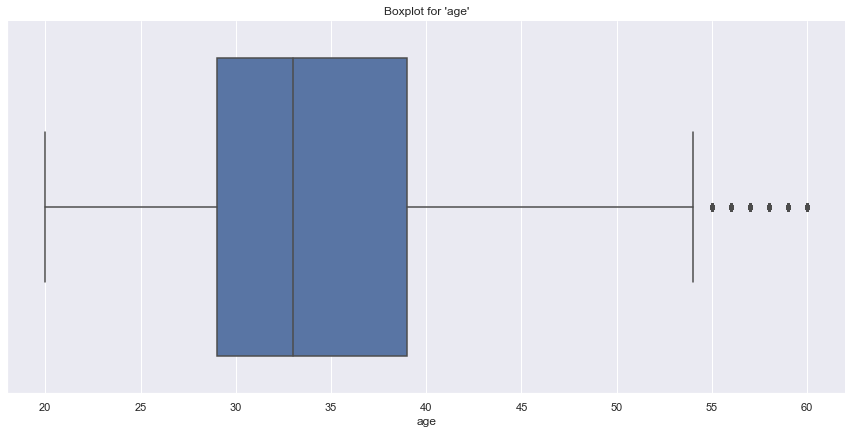

In [179]:
#Boxplot to investigate anomalies in "age"
department_count = sns.catplot(x="age", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'age'")
plt.show()
department_count.savefig("boxplot_age.png")

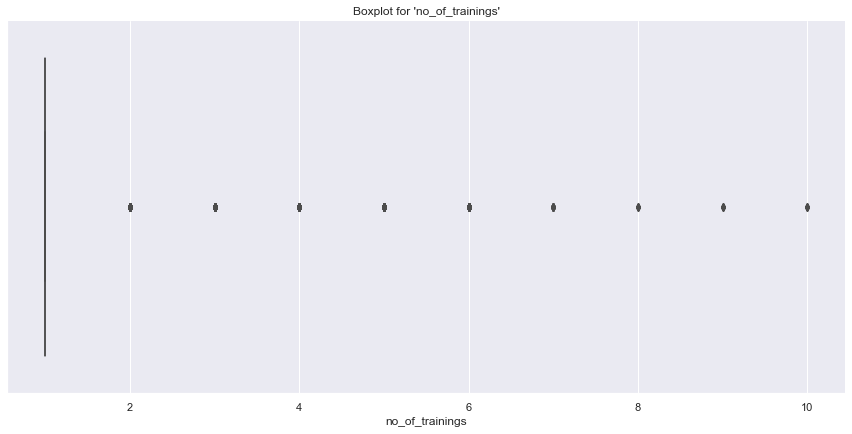

In [180]:
#Boxplot to investigate anomalies in "previous_year_rating"
department_count = sns.catplot(x="no_of_trainings", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'no_of_trainings'")
plt.show()
department_count.savefig("boxplot_trainings.png")

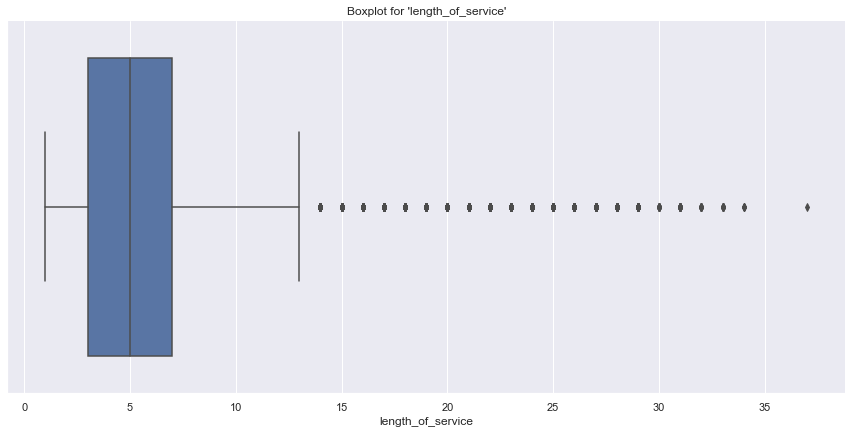

In [181]:
#Boxplot to investigate anomalies in "length_of_service"
department_count = sns.catplot(x="length_of_service", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'length_of_service'")
plt.show()
department_count.savefig("boxplot_service.png")

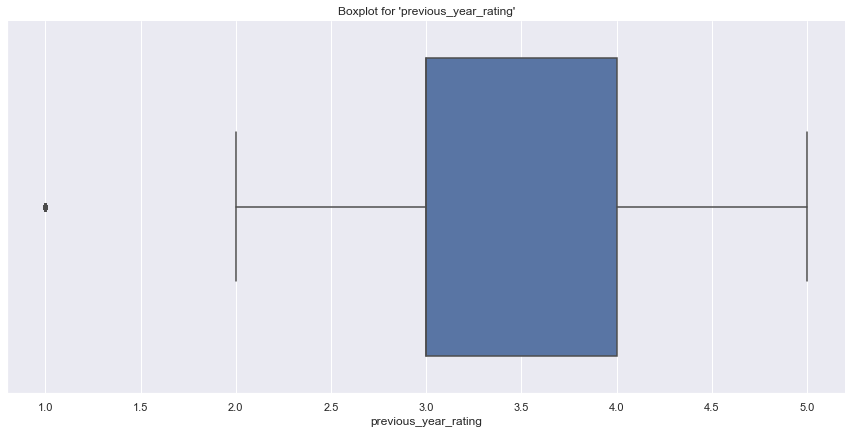

In [182]:
#Boxplot to investigate anomalies in "previous_year_rating"
department_count = sns.catplot(x="previous_year_rating", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'previous_year_rating'")
plt.show()
department_count.savefig("boxplot_rating.png")

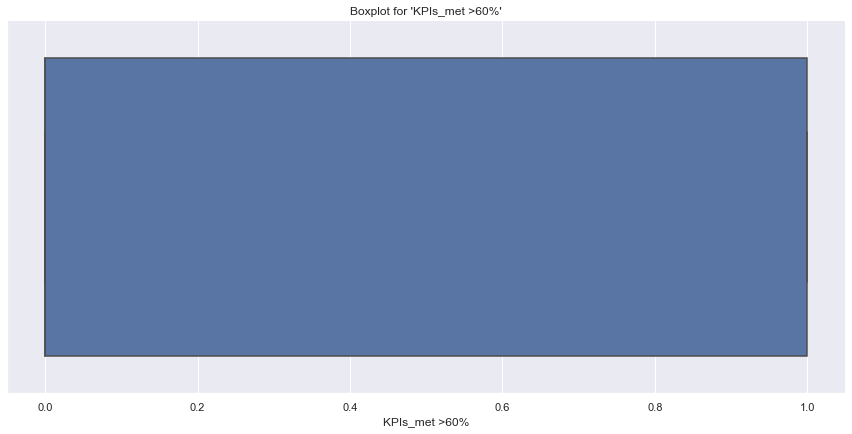

In [183]:
#Boxplot to investigate anomalies in "KPIs_met >60%"
department_count = sns.catplot(x="KPIs_met >60%", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'KPIs_met >60%'")
plt.show()
department_count.savefig("boxplot_KPI.png")

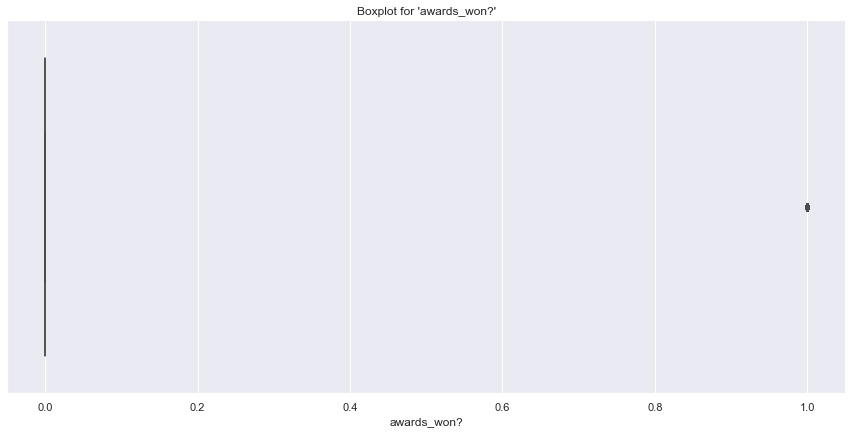

In [184]:
#Boxplot to investigate anomalies in "awards_won?"
department_count = sns.catplot(x="awards_won?", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'awards_won?'")
plt.show()
department_count.savefig("boxplot_awards.png")

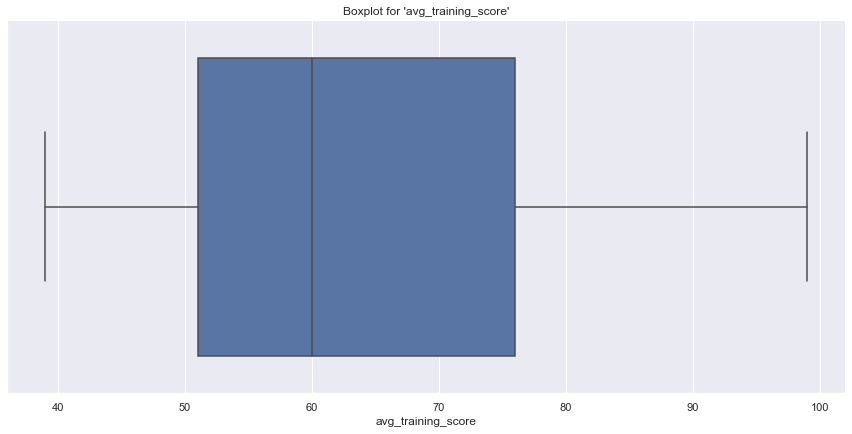

In [185]:
#Boxplot to investigate anomalies in "avg_training_score?"
department_count = sns.catplot(x="avg_training_score", kind="box", height=6, aspect=2, data = trainset_copy)
plt.title("Boxplot for 'avg_training_score'")
plt.show()
department_count.savefig("boxplot_score.png")

### Other Visualisations

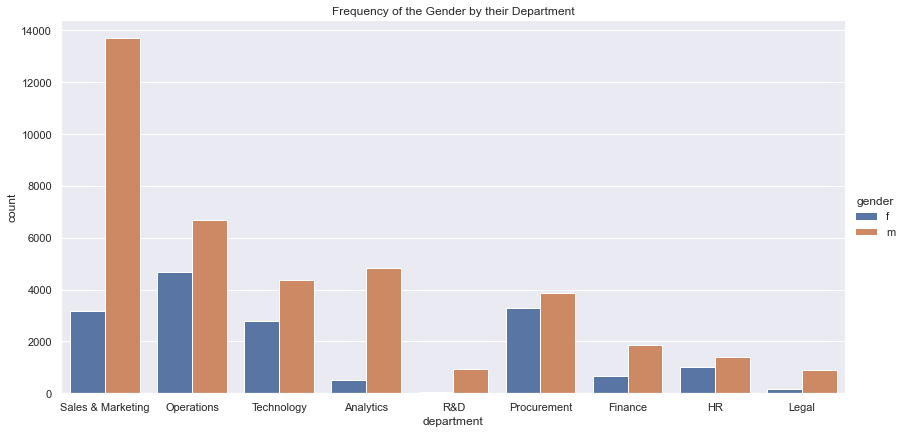

In [186]:
#Countplot showing the freqency of the gender by their department
department_count = sns.catplot(x="department", hue = "gender", kind="count", height=6, aspect=2, data = trainset_copy)
plt.title("Frequency of the Gender by their Department")
plt.show()
department_count.savefig("department_count.png")

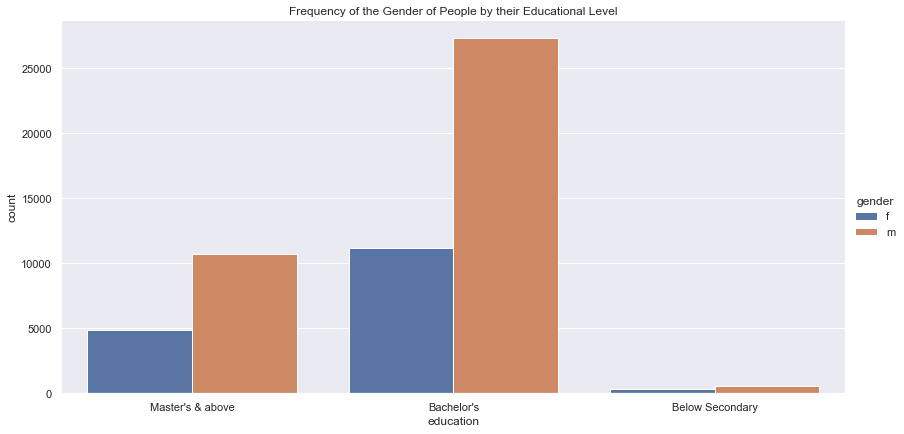

In [187]:
#Countplot showing the freqency of the gender of people by their educational level
education_count = sns.catplot(x="education", hue = 'gender', kind="count", height=6, aspect=2, data = trainset_copy)
plt.title("Frequency of the Gender of People by their Educational Level")
plt.show()
education_count.savefig("education_gender_count.png")

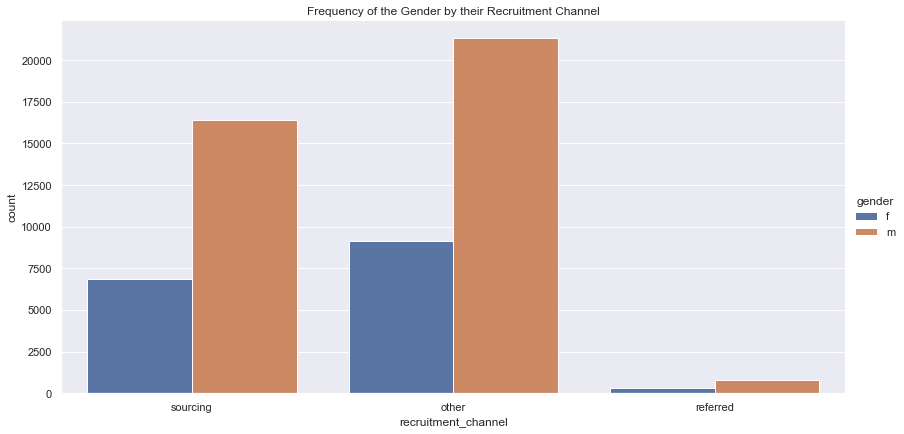

In [188]:
#Countplot showing the freqency of gender by their recuitment channel
recruitment_count = sns.catplot(x="recruitment_channel", hue = "gender", kind="count", height=6, aspect=2, data = trainset_copy)
plt.title("Frequency of the Gender by their Recruitment Channel")
plt.show()
recruitment_count.savefig("recruitment_count.png")

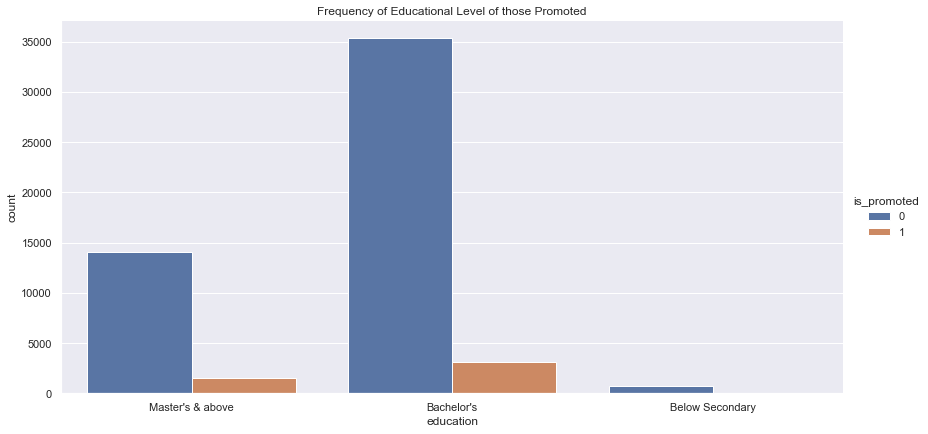

In [189]:
#Countplot of Frequency of Educational Level of those Promoted
education_promoted_count = sns.catplot(data=trainset_copy, x="education", hue="is_promoted", kind="count", height=6, aspect=2)
plt.title("Frequency of Educational Level of those Promoted")
plt.show()
education_promoted_count.savefig("education_promoted_count.png")

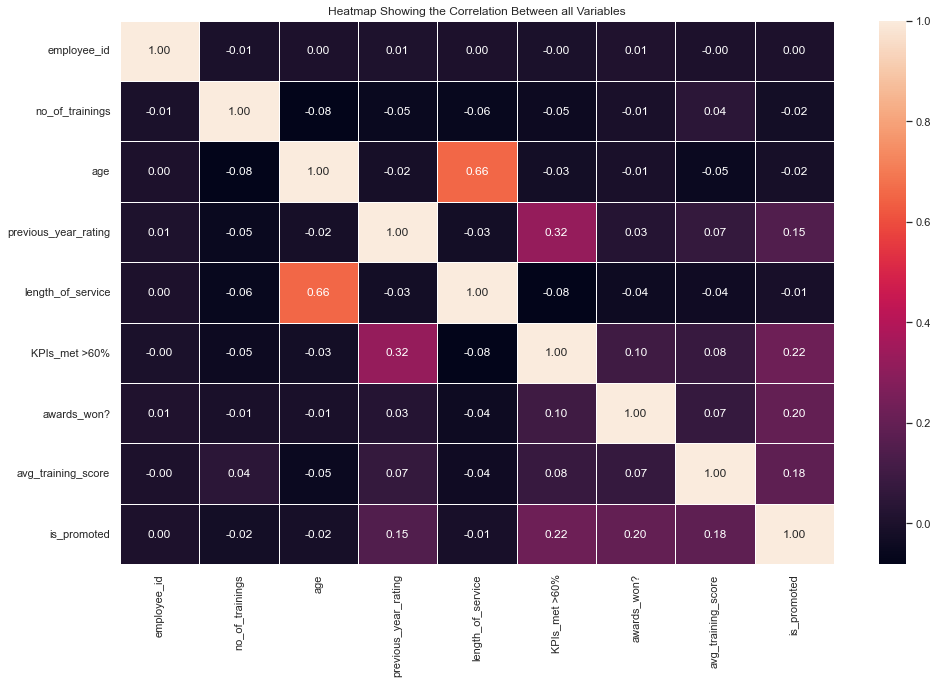

In [190]:
#Heatmap showing the correlation between all variables
plt.figure(figsize=(16,10))
trainset_heatmap = sns.heatmap(data=trainset_copy.corr(), annot=True, fmt=".2f", linewidths=1)
plt.title("Heatmap Showing the Correlation Between all Variables")
plt.savefig("Heatmap.png")
plt.show()

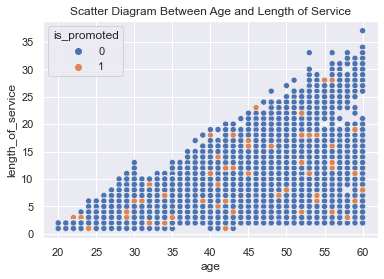

In [191]:
#Graph showing the scatter diagram between all variables
age_scatter = sns.scatterplot(x="age", y="length_of_service", hue="is_promoted", data=trainset_copy)
plt.title("Scatter Diagram Between Age and Length of Service")
plt.show()

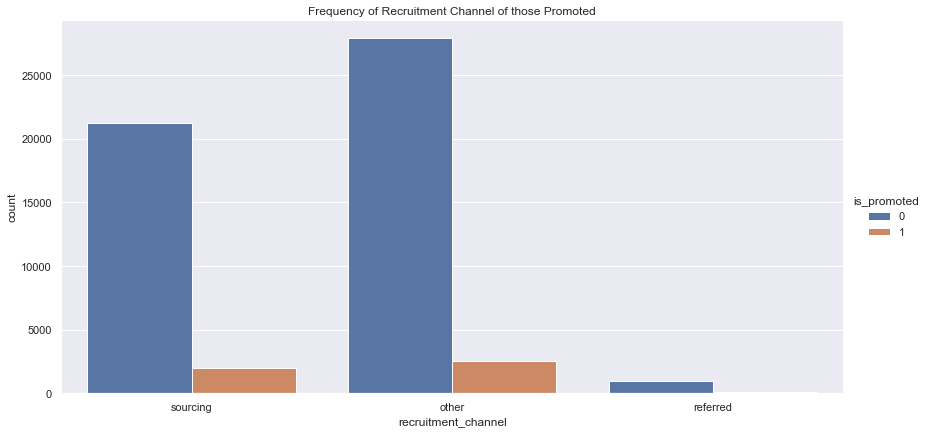

In [192]:
#Graph of Frequency of Recruitment Channel of those Promoted
recruitment_promoted = sns.catplot(data=trainset_copy, x="recruitment_channel", hue="is_promoted", kind="count", height=6, aspect=2)
plt.title("Frequency of Recruitment Channel of those Promoted")
plt.show()
recruitment_promoted.savefig("recruitment_promoted.png")

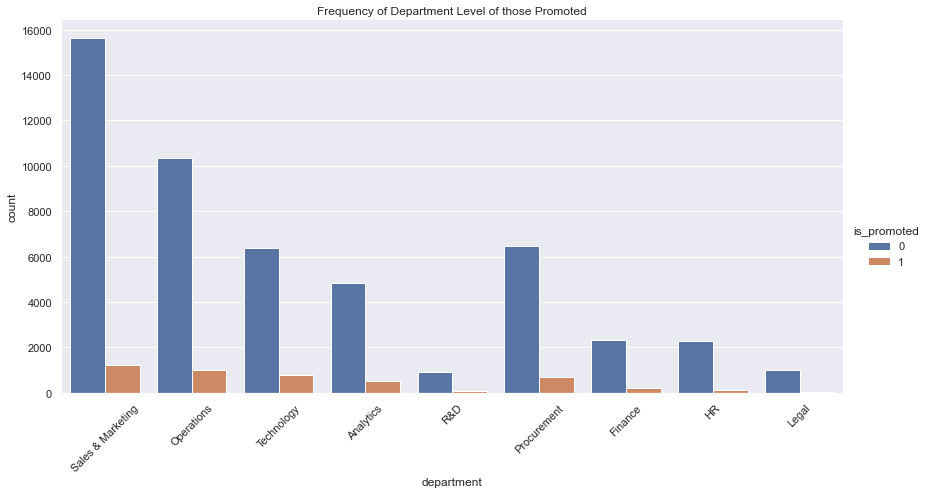

In [193]:
#Graph of Frequency of Department Level of those Promoted
department_promoted = sns.catplot(data=trainset_copy, x="department", hue="is_promoted", kind="count", height=6, aspect=2)
plt.title("Frequency of Department Level of those Promoted")
plt.xticks(rotation=45)
plt.show()
department_promoted.savefig("department_promoted.png")

# Catboost Classifier Model 

## Feature Selection

In [194]:
X = trainset_copy.drop(["employee_id", "is_promoted"], axis=1)
y = trainset_copy["is_promoted"]

### Build the Model

In [195]:
#Build the Model
cate_features_index = np.where((X.dtypes != float) & (X.dtypes != int))[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1200)

cat = CatBoostClassifier(eval_metric='Accuracy', use_best_model=True, random_seed=40, loss_function='MultiClass', learning_rate = 0.674, iterations = 700, depth = 4, bagging_temperature=3, one_hot_max_size=2)
cat.fit(X_train, y_train, cat_features=cate_features_index, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.9170352	test: 0.9164437	best: 0.9164437 (0)	total: 363ms	remaining: 4m 14s
1:	learn: 0.9234105	test: 0.9238628	best: 0.9238628 (1)	total: 467ms	remaining: 2m 43s
2:	learn: 0.9396814	test: 0.9419849	best: 0.9419849 (2)	total: 551ms	remaining: 2m 8s
3:	learn: 0.9405615	test: 0.9427147	best: 0.9427147 (3)	total: 636ms	remaining: 1m 50s
4:	learn: 0.9398746	test: 0.9424714	best: 0.9427147 (3)	total: 746ms	remaining: 1m 43s
5:	learn: 0.9400893	test: 0.9427147	best: 0.9427147 (3)	total: 889ms	remaining: 1m 42s
6:	learn: 0.9405615	test: 0.9428363	best: 0.9428363 (6)	total: 1.02s	remaining: 1m 41s
7:	learn: 0.9402610	test: 0.9423498	best: 0.9428363 (6)	total: 1.12s	remaining: 1m 37s
8:	learn: 0.9405830	test: 0.9425930	best: 0.9428363 (6)	total: 1.21s	remaining: 1m 32s
9:	learn: 0.9406259	test: 0.9425930	best: 0.9428363 (6)	total: 1.3s	remaining: 1m 29s
10:	learn: 0.9410982	test: 0.9429579	best: 0.9429579 (10)	total: 1.39s	remaining: 1m 26s
11:	learn: 0.9410553	test: 0.9429579	best: 

95:	learn: 0.9423432	test: 0.9433228	best: 0.9434444 (83)	total: 8.73s	remaining: 54.9s
96:	learn: 0.9423432	test: 0.9433228	best: 0.9434444 (83)	total: 8.82s	remaining: 54.8s
97:	learn: 0.9424291	test: 0.9433228	best: 0.9434444 (83)	total: 8.89s	remaining: 54.6s
98:	learn: 0.9425578	test: 0.9430795	best: 0.9434444 (83)	total: 8.98s	remaining: 54.5s
99:	learn: 0.9424720	test: 0.9429579	best: 0.9434444 (83)	total: 9.07s	remaining: 54.4s
100:	learn: 0.9424720	test: 0.9429579	best: 0.9434444 (83)	total: 9.15s	remaining: 54.3s
101:	learn: 0.9424291	test: 0.9429579	best: 0.9434444 (83)	total: 9.22s	remaining: 54.1s
102:	learn: 0.9424935	test: 0.9429579	best: 0.9434444 (83)	total: 9.31s	remaining: 54s
103:	learn: 0.9424720	test: 0.9429579	best: 0.9434444 (83)	total: 9.39s	remaining: 53.8s
104:	learn: 0.9424720	test: 0.9429579	best: 0.9434444 (83)	total: 9.49s	remaining: 53.8s
105:	learn: 0.9424720	test: 0.9429579	best: 0.9434444 (83)	total: 9.57s	remaining: 53.7s
106:	learn: 0.9424720	test: 

189:	learn: 0.9436741	test: 0.9433228	best: 0.9438093 (163)	total: 16.6s	remaining: 44.5s
190:	learn: 0.9436955	test: 0.9434444	best: 0.9438093 (163)	total: 16.7s	remaining: 44.4s
191:	learn: 0.9436311	test: 0.9434444	best: 0.9438093 (163)	total: 16.8s	remaining: 44.3s
192:	learn: 0.9437599	test: 0.9434444	best: 0.9438093 (163)	total: 16.9s	remaining: 44.3s
193:	learn: 0.9437814	test: 0.9433228	best: 0.9438093 (163)	total: 16.9s	remaining: 44.2s
194:	learn: 0.9438458	test: 0.9433228	best: 0.9438093 (163)	total: 17s	remaining: 44.1s
195:	learn: 0.9438887	test: 0.9433228	best: 0.9438093 (163)	total: 17.1s	remaining: 44s
196:	learn: 0.9437814	test: 0.9433228	best: 0.9438093 (163)	total: 17.2s	remaining: 43.8s
197:	learn: 0.9437814	test: 0.9434444	best: 0.9438093 (163)	total: 17.3s	remaining: 43.8s
198:	learn: 0.9437814	test: 0.9435660	best: 0.9438093 (163)	total: 17.4s	remaining: 43.7s
199:	learn: 0.9438029	test: 0.9434444	best: 0.9438093 (163)	total: 17.4s	remaining: 43.6s
200:	learn: 0.

281:	learn: 0.9445112	test: 0.9435660	best: 0.9438093 (163)	total: 24.3s	remaining: 36s
282:	learn: 0.9445112	test: 0.9435660	best: 0.9438093 (163)	total: 24.4s	remaining: 35.9s
283:	learn: 0.9446186	test: 0.9438093	best: 0.9438093 (163)	total: 24.5s	remaining: 35.9s
284:	learn: 0.9446830	test: 0.9438093	best: 0.9438093 (163)	total: 24.6s	remaining: 35.8s
285:	learn: 0.9448117	test: 0.9435660	best: 0.9438093 (163)	total: 24.7s	remaining: 35.7s
286:	learn: 0.9448332	test: 0.9435660	best: 0.9438093 (163)	total: 24.7s	remaining: 35.6s
287:	learn: 0.9447903	test: 0.9434444	best: 0.9438093 (163)	total: 24.8s	remaining: 35.5s
288:	learn: 0.9447903	test: 0.9435660	best: 0.9438093 (163)	total: 24.9s	remaining: 35.4s
289:	learn: 0.9447903	test: 0.9435660	best: 0.9438093 (163)	total: 25s	remaining: 35.3s
290:	learn: 0.9447473	test: 0.9435660	best: 0.9438093 (163)	total: 25s	remaining: 35.2s
291:	learn: 0.9447473	test: 0.9436877	best: 0.9438093 (163)	total: 25.1s	remaining: 35.1s
292:	learn: 0.94

375:	learn: 0.9457562	test: 0.9428363	best: 0.9439309 (296)	total: 32.2s	remaining: 27.7s
376:	learn: 0.9457133	test: 0.9427147	best: 0.9439309 (296)	total: 32.2s	remaining: 27.6s
377:	learn: 0.9457777	test: 0.9425930	best: 0.9439309 (296)	total: 32.3s	remaining: 27.5s
378:	learn: 0.9458206	test: 0.9428363	best: 0.9439309 (296)	total: 32.4s	remaining: 27.5s
379:	learn: 0.9457562	test: 0.9430795	best: 0.9439309 (296)	total: 32.5s	remaining: 27.4s
380:	learn: 0.9458206	test: 0.9430795	best: 0.9439309 (296)	total: 32.6s	remaining: 27.3s
381:	learn: 0.9458636	test: 0.9432012	best: 0.9439309 (296)	total: 32.7s	remaining: 27.2s
382:	learn: 0.9458636	test: 0.9432012	best: 0.9439309 (296)	total: 32.8s	remaining: 27.1s
383:	learn: 0.9459065	test: 0.9432012	best: 0.9439309 (296)	total: 32.9s	remaining: 27s
384:	learn: 0.9459065	test: 0.9432012	best: 0.9439309 (296)	total: 33s	remaining: 27s
385:	learn: 0.9460138	test: 0.9435660	best: 0.9439309 (296)	total: 33.1s	remaining: 26.9s
386:	learn: 0.94

468:	learn: 0.9469154	test: 0.9424714	best: 0.9439309 (296)	total: 40.6s	remaining: 20s
469:	learn: 0.9468295	test: 0.9424714	best: 0.9439309 (296)	total: 40.8s	remaining: 19.9s
470:	learn: 0.9468081	test: 0.9424714	best: 0.9439309 (296)	total: 40.9s	remaining: 19.9s
471:	learn: 0.9468295	test: 0.9424714	best: 0.9439309 (296)	total: 41s	remaining: 19.8s
472:	learn: 0.9469368	test: 0.9423498	best: 0.9439309 (296)	total: 41.1s	remaining: 19.7s
473:	learn: 0.9468939	test: 0.9421065	best: 0.9439309 (296)	total: 41.1s	remaining: 19.6s
474:	learn: 0.9468939	test: 0.9423498	best: 0.9439309 (296)	total: 41.2s	remaining: 19.5s
475:	learn: 0.9469583	test: 0.9423498	best: 0.9439309 (296)	total: 41.3s	remaining: 19.4s
476:	learn: 0.9470227	test: 0.9424714	best: 0.9439309 (296)	total: 41.4s	remaining: 19.4s
477:	learn: 0.9469798	test: 0.9424714	best: 0.9439309 (296)	total: 41.5s	remaining: 19.3s
478:	learn: 0.9470227	test: 0.9424714	best: 0.9439309 (296)	total: 41.6s	remaining: 19.2s
479:	learn: 0.

561:	learn: 0.9476881	test: 0.9425930	best: 0.9439309 (296)	total: 48.6s	remaining: 11.9s
562:	learn: 0.9477096	test: 0.9424714	best: 0.9439309 (296)	total: 48.7s	remaining: 11.9s
563:	learn: 0.9477311	test: 0.9423498	best: 0.9439309 (296)	total: 48.8s	remaining: 11.8s
564:	learn: 0.9477740	test: 0.9422282	best: 0.9439309 (296)	total: 48.9s	remaining: 11.7s
565:	learn: 0.9477740	test: 0.9424714	best: 0.9439309 (296)	total: 48.9s	remaining: 11.6s
566:	learn: 0.9478384	test: 0.9424714	best: 0.9439309 (296)	total: 49s	remaining: 11.5s
567:	learn: 0.9477525	test: 0.9425930	best: 0.9439309 (296)	total: 49.1s	remaining: 11.4s
568:	learn: 0.9478384	test: 0.9423498	best: 0.9439309 (296)	total: 49.2s	remaining: 11.3s
569:	learn: 0.9478169	test: 0.9423498	best: 0.9439309 (296)	total: 49.3s	remaining: 11.2s
570:	learn: 0.9478599	test: 0.9421065	best: 0.9439309 (296)	total: 49.4s	remaining: 11.2s
571:	learn: 0.9478599	test: 0.9422282	best: 0.9439309 (296)	total: 49.5s	remaining: 11.1s
572:	learn: 

654:	learn: 0.9487614	test: 0.9423498	best: 0.9439309 (296)	total: 56.4s	remaining: 3.87s
655:	learn: 0.9488044	test: 0.9424714	best: 0.9439309 (296)	total: 56.5s	remaining: 3.79s
656:	learn: 0.9488044	test: 0.9427147	best: 0.9439309 (296)	total: 56.5s	remaining: 3.7s
657:	learn: 0.9488902	test: 0.9427147	best: 0.9439309 (296)	total: 56.6s	remaining: 3.62s
658:	learn: 0.9488902	test: 0.9429579	best: 0.9439309 (296)	total: 56.7s	remaining: 3.53s
659:	learn: 0.9489117	test: 0.9428363	best: 0.9439309 (296)	total: 56.8s	remaining: 3.44s
660:	learn: 0.9489332	test: 0.9429579	best: 0.9439309 (296)	total: 56.9s	remaining: 3.36s
661:	learn: 0.9489332	test: 0.9427147	best: 0.9439309 (296)	total: 57s	remaining: 3.27s
662:	learn: 0.9488902	test: 0.9427147	best: 0.9439309 (296)	total: 57s	remaining: 3.18s
663:	learn: 0.9489546	test: 0.9427147	best: 0.9439309 (296)	total: 57.1s	remaining: 3.1s
664:	learn: 0.9491478	test: 0.9424714	best: 0.9439309 (296)	total: 57.2s	remaining: 3.01s
665:	learn: 0.94

### First Predictions and Evaluation

The Test Accuracy is :			0.943931
----------------------------------------------
Training set score:			94.41%
Test set score:				94.39%
The f1_score:  [0.9701869  0.53007136]
----------------------------------------------


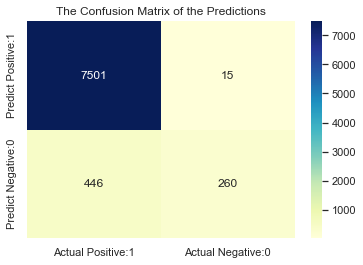

In [196]:
print('The Test Accuracy is :\t\t\t{:.6f}'.format(accuracy_score(y_test, cat.predict(X_test))))
predcat = cat.predict(X_test)
print("----------------------------------------------")
print(f"Training set score:\t\t\t{cat.score(X_train, y_train)*100:.4}%")
print(f"Test set score:\t\t\t\t{cat.score(X_test, y_test)*100:.4}%")
print(f"The f1_score: ", f1_score(y_test, cat.predict(X_test), average=None))

print("----------------------------------------------")

#The Confusion Matrix of the Predictions
cm = confusion_matrix(y_test, cat.predict(X_test), labels=[0, 1])
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("The Confusion Matrix of the Predictions")
plt.savefig("first_confusion.png")
plt.show()

### Summary of First Predictions

0    22756
1      734
dtype: int64


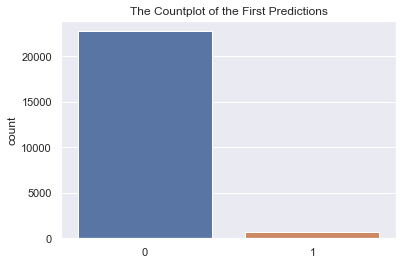

In [197]:
#Summary of First Predictions
testset_copy = testset_copy.drop("employee_id", axis=1)
preds = cat.predict(testset_copy)
pred1 = preds.flatten()
predlst = pred1.tolist()
first_predictions = pd.DataFrame({"employee_id": testset.employee_id , "is_promoted": predlst})
first_predictions.to_csv("first_predictions.csv", index=False)
print(pd.Series(predlst).value_counts())
first_predictions_image = sns.countplot(predlst)
plt.title("The Countplot of the First Predictions")
plt.savefig("first_counts.png")

In [198]:
#The Classification Report
print("The Classification Report")
print(classification_report(y_test, cat.predict(X_test)))

The Classification Report
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7516
           1       0.95      0.37      0.53       706

    accuracy                           0.94      8222
   macro avg       0.94      0.68      0.75      8222
weighted avg       0.94      0.94      0.93      8222



In [199]:
# So We Were able to Predict that 718 were promoted while 22772 were not, which is on a model Accuracy of 94

In [200]:
# export the cleaned data set for model deployment
trainset_copy.to_csv("trainset_cleaned.csv", index=False)
testset_copy.to_csv("testset_cleaned.csv", index=False)

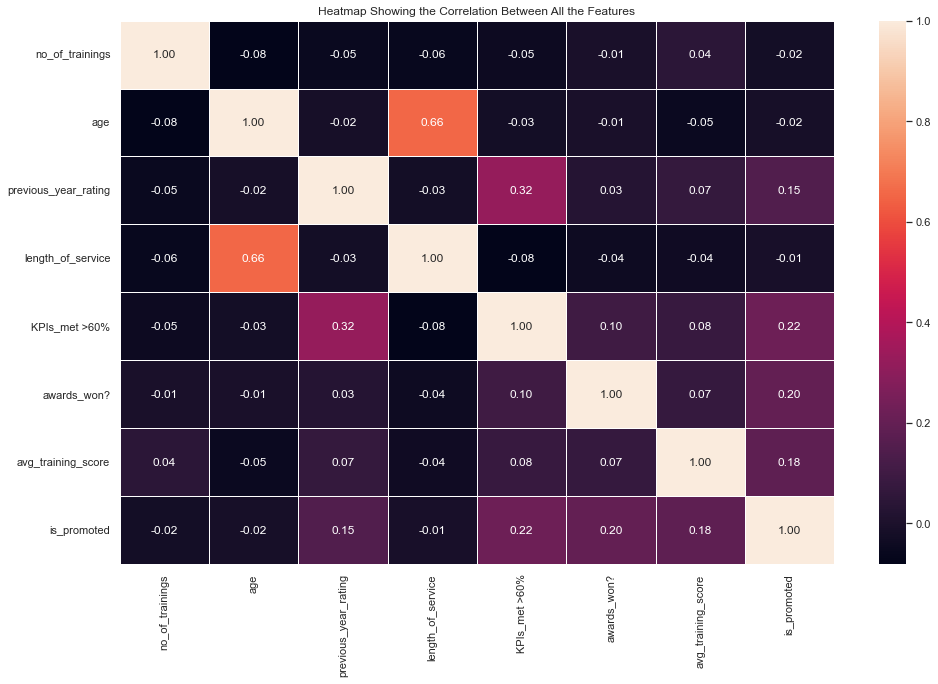

In [201]:
#Heatmap showing the correlation between all variables
heat_train = trainset_copy.drop("employee_id", axis=1)
plt.figure(figsize=(16, 10))
sns.heatmap(data=heat_train.corr(), annot=True, fmt=".2f", linewidths=1)
plt.title("Heatmap Showing the Correlation Between All the Features")
plt.savefig("Heatmap.png")
plt.show()

### Re-selecting the Features Based on the Result of the Heatmap

In [202]:
#Reselect the features based on the result of the heatmap
X = trainset_copy[["age", "previous_year_rating", "KPIs_met >60%", "awards_won?", "avg_training_score"]]
y = trainset_copy["is_promoted"]

In [203]:
#Rebuild the CatBoost Model
cate_features_index = np.where(X.dtypes != float)[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1200)


cat = CatBoostClassifier(eval_metric='Accuracy', use_best_model=True, random_seed=40, loss_function='MultiClass', learning_rate = 0.674, iterations = 700, depth = 4, bagging_temperature=3, one_hot_max_size=2)
cat.fit(X_train, y_train, cat_features=cate_features_index, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.9167561	test: 0.9157139	best: 0.9157139 (0)	total: 47.2ms	remaining: 33s
1:	learn: 0.9165415	test: 0.9152274	best: 0.9157139 (0)	total: 91.3ms	remaining: 31.9s
2:	learn: 0.9243764	test: 0.9254439	best: 0.9254439 (2)	total: 131ms	remaining: 30.4s
3:	learn: 0.9240759	test: 0.9253223	best: 0.9254439 (2)	total: 168ms	remaining: 29.2s
4:	learn: 0.9242262	test: 0.9249574	best: 0.9254439 (2)	total: 213ms	remaining: 29.6s
5:	learn: 0.9241832	test: 0.9255656	best: 0.9255656 (5)	total: 256ms	remaining: 29.6s
6:	learn: 0.9242262	test: 0.9254439	best: 0.9255656 (5)	total: 306ms	remaining: 30.3s
7:	learn: 0.9243120	test: 0.9254439	best: 0.9255656 (5)	total: 350ms	remaining: 30.2s
8:	learn: 0.9243335	test: 0.9254439	best: 0.9255656 (5)	total: 388ms	remaining: 29.8s
9:	learn: 0.9245481	test: 0.9243493	best: 0.9255656 (5)	total: 421ms	remaining: 29.1s
10:	learn: 0.9245267	test: 0.9247142	best: 0.9255656 (5)	total: 453ms	remaining: 28.4s
11:	learn: 0.9243764	test: 0.9249574	best: 0.9255656 

95:	learn: 0.9260722	test: 0.9244709	best: 0.9255656 (5)	total: 4.23s	remaining: 26.6s
96:	learn: 0.9260507	test: 0.9247142	best: 0.9255656 (5)	total: 4.29s	remaining: 26.7s
97:	learn: 0.9261366	test: 0.9248358	best: 0.9255656 (5)	total: 4.34s	remaining: 26.7s
98:	learn: 0.9262010	test: 0.9245926	best: 0.9255656 (5)	total: 4.38s	remaining: 26.6s
99:	learn: 0.9262439	test: 0.9245926	best: 0.9255656 (5)	total: 4.41s	remaining: 26.5s
100:	learn: 0.9263298	test: 0.9244709	best: 0.9255656 (5)	total: 4.45s	remaining: 26.4s
101:	learn: 0.9263298	test: 0.9245926	best: 0.9255656 (5)	total: 4.5s	remaining: 26.4s
102:	learn: 0.9263727	test: 0.9248358	best: 0.9255656 (5)	total: 4.54s	remaining: 26.3s
103:	learn: 0.9263513	test: 0.9245926	best: 0.9255656 (5)	total: 4.57s	remaining: 26.2s
104:	learn: 0.9263298	test: 0.9245926	best: 0.9255656 (5)	total: 4.61s	remaining: 26.1s
105:	learn: 0.9263727	test: 0.9244709	best: 0.9255656 (5)	total: 4.65s	remaining: 26s
106:	learn: 0.9263727	test: 0.9244709	be

189:	learn: 0.9269094	test: 0.9247142	best: 0.9255656 (5)	total: 7.88s	remaining: 21.1s
190:	learn: 0.9269308	test: 0.9247142	best: 0.9255656 (5)	total: 7.92s	remaining: 21.1s
191:	learn: 0.9269094	test: 0.9247142	best: 0.9255656 (5)	total: 7.95s	remaining: 21s
192:	learn: 0.9269738	test: 0.9245926	best: 0.9255656 (5)	total: 7.98s	remaining: 21s
193:	learn: 0.9270167	test: 0.9245926	best: 0.9255656 (5)	total: 8.02s	remaining: 20.9s
194:	learn: 0.9270167	test: 0.9247142	best: 0.9255656 (5)	total: 8.05s	remaining: 20.9s
195:	learn: 0.9270382	test: 0.9247142	best: 0.9255656 (5)	total: 8.1s	remaining: 20.8s
196:	learn: 0.9270382	test: 0.9247142	best: 0.9255656 (5)	total: 8.13s	remaining: 20.8s
197:	learn: 0.9270167	test: 0.9247142	best: 0.9255656 (5)	total: 8.17s	remaining: 20.7s
198:	learn: 0.9270382	test: 0.9247142	best: 0.9255656 (5)	total: 8.21s	remaining: 20.7s
199:	learn: 0.9271026	test: 0.9248358	best: 0.9255656 (5)	total: 8.26s	remaining: 20.6s
200:	learn: 0.9270811	test: 0.9248358

284:	learn: 0.9275748	test: 0.9248358	best: 0.9255656 (5)	total: 11.4s	remaining: 16.6s
285:	learn: 0.9276821	test: 0.9249574	best: 0.9255656 (5)	total: 11.4s	remaining: 16.5s
286:	learn: 0.9276177	test: 0.9248358	best: 0.9255656 (5)	total: 11.5s	remaining: 16.5s
287:	learn: 0.9276607	test: 0.9249574	best: 0.9255656 (5)	total: 11.5s	remaining: 16.5s
288:	learn: 0.9276821	test: 0.9249574	best: 0.9255656 (5)	total: 11.5s	remaining: 16.4s
289:	learn: 0.9275963	test: 0.9249574	best: 0.9255656 (5)	total: 11.6s	remaining: 16.4s
290:	learn: 0.9276392	test: 0.9249574	best: 0.9255656 (5)	total: 11.6s	remaining: 16.3s
291:	learn: 0.9276607	test: 0.9248358	best: 0.9255656 (5)	total: 11.6s	remaining: 16.3s
292:	learn: 0.9277680	test: 0.9249574	best: 0.9255656 (5)	total: 11.7s	remaining: 16.2s
293:	learn: 0.9278109	test: 0.9252007	best: 0.9255656 (5)	total: 11.7s	remaining: 16.2s
294:	learn: 0.9278109	test: 0.9252007	best: 0.9255656 (5)	total: 11.8s	remaining: 16.1s
295:	learn: 0.9278109	test: 0.92

378:	learn: 0.9283046	test: 0.9250791	best: 0.9255656 (5)	total: 14.8s	remaining: 12.6s
379:	learn: 0.9283261	test: 0.9250791	best: 0.9255656 (5)	total: 14.9s	remaining: 12.5s
380:	learn: 0.9283690	test: 0.9250791	best: 0.9255656 (5)	total: 14.9s	remaining: 12.5s
381:	learn: 0.9284120	test: 0.9253223	best: 0.9255656 (5)	total: 15s	remaining: 12.5s
382:	learn: 0.9283905	test: 0.9252007	best: 0.9255656 (5)	total: 15s	remaining: 12.4s
383:	learn: 0.9283690	test: 0.9253223	best: 0.9255656 (5)	total: 15s	remaining: 12.4s
384:	learn: 0.9283261	test: 0.9253223	best: 0.9255656 (5)	total: 15.1s	remaining: 12.3s
385:	learn: 0.9282832	test: 0.9252007	best: 0.9255656 (5)	total: 15.1s	remaining: 12.3s
386:	learn: 0.9282617	test: 0.9252007	best: 0.9255656 (5)	total: 15.1s	remaining: 12.3s
387:	learn: 0.9283261	test: 0.9253223	best: 0.9255656 (5)	total: 15.2s	remaining: 12.2s
388:	learn: 0.9283046	test: 0.9250791	best: 0.9255656 (5)	total: 15.2s	remaining: 12.2s
389:	learn: 0.9283690	test: 0.9252007	

475:	learn: 0.9287554	test: 0.9239844	best: 0.9255656 (5)	total: 18.4s	remaining: 8.67s
476:	learn: 0.9287125	test: 0.9239844	best: 0.9255656 (5)	total: 18.5s	remaining: 8.63s
477:	learn: 0.9287554	test: 0.9238628	best: 0.9255656 (5)	total: 18.5s	remaining: 8.59s
478:	learn: 0.9287554	test: 0.9238628	best: 0.9255656 (5)	total: 18.5s	remaining: 8.55s
479:	learn: 0.9288198	test: 0.9238628	best: 0.9255656 (5)	total: 18.6s	remaining: 8.51s
480:	learn: 0.9288842	test: 0.9239844	best: 0.9255656 (5)	total: 18.6s	remaining: 8.47s
481:	learn: 0.9288198	test: 0.9239844	best: 0.9255656 (5)	total: 18.7s	remaining: 8.44s
482:	learn: 0.9287984	test: 0.9238628	best: 0.9255656 (5)	total: 18.7s	remaining: 8.4s
483:	learn: 0.9288198	test: 0.9238628	best: 0.9255656 (5)	total: 18.7s	remaining: 8.36s
484:	learn: 0.9288627	test: 0.9238628	best: 0.9255656 (5)	total: 18.8s	remaining: 8.31s
485:	learn: 0.9288198	test: 0.9238628	best: 0.9255656 (5)	total: 18.8s	remaining: 8.27s
486:	learn: 0.9287554	test: 0.923

571:	learn: 0.9293994	test: 0.9244709	best: 0.9255656 (5)	total: 22s	remaining: 4.91s
572:	learn: 0.9293779	test: 0.9244709	best: 0.9255656 (5)	total: 22s	remaining: 4.87s
573:	learn: 0.9294423	test: 0.9243493	best: 0.9255656 (5)	total: 22s	remaining: 4.83s
574:	learn: 0.9294209	test: 0.9244709	best: 0.9255656 (5)	total: 22.1s	remaining: 4.8s
575:	learn: 0.9294638	test: 0.9244709	best: 0.9255656 (5)	total: 22.1s	remaining: 4.76s
576:	learn: 0.9294423	test: 0.9244709	best: 0.9255656 (5)	total: 22.1s	remaining: 4.72s
577:	learn: 0.9295067	test: 0.9243493	best: 0.9255656 (5)	total: 22.2s	remaining: 4.68s
578:	learn: 0.9295067	test: 0.9243493	best: 0.9255656 (5)	total: 22.2s	remaining: 4.64s
579:	learn: 0.9295497	test: 0.9243493	best: 0.9255656 (5)	total: 22.3s	remaining: 4.6s
580:	learn: 0.9294853	test: 0.9245926	best: 0.9255656 (5)	total: 22.3s	remaining: 4.57s
581:	learn: 0.9296140	test: 0.9243493	best: 0.9255656 (5)	total: 22.3s	remaining: 4.53s
582:	learn: 0.9295282	test: 0.9243493	be

668:	learn: 0.9298716	test: 0.9239844	best: 0.9255656 (5)	total: 25.5s	remaining: 1.18s
669:	learn: 0.9298931	test: 0.9239844	best: 0.9255656 (5)	total: 25.6s	remaining: 1.14s
670:	learn: 0.9299575	test: 0.9239844	best: 0.9255656 (5)	total: 25.6s	remaining: 1.11s
671:	learn: 0.9299790	test: 0.9239844	best: 0.9255656 (5)	total: 25.6s	remaining: 1.07s
672:	learn: 0.9298931	test: 0.9241061	best: 0.9255656 (5)	total: 25.7s	remaining: 1.03s
673:	learn: 0.9298931	test: 0.9241061	best: 0.9255656 (5)	total: 25.7s	remaining: 992ms
674:	learn: 0.9299146	test: 0.9241061	best: 0.9255656 (5)	total: 25.8s	remaining: 954ms
675:	learn: 0.9298502	test: 0.9241061	best: 0.9255656 (5)	total: 25.8s	remaining: 916ms
676:	learn: 0.9298716	test: 0.9241061	best: 0.9255656 (5)	total: 25.8s	remaining: 877ms
677:	learn: 0.9300863	test: 0.9238628	best: 0.9255656 (5)	total: 25.9s	remaining: 839ms
678:	learn: 0.9300004	test: 0.9238628	best: 0.9255656 (5)	total: 25.9s	remaining: 801ms
679:	learn: 0.9300648	test: 0.92

### Second Predictions and Evaluation

The Test Accuracy is :			0.925566
----------------------------------------------
Training set score:			92.46%
Test set score:				92.56%
The f1_score:  [0.96079939 0.26442308]
----------------------------------------------


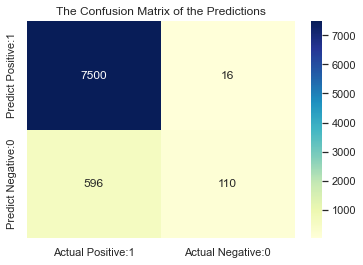

In [204]:
#Make predictions on the test dataset
print('The Test Accuracy is :\t\t\t{:.6f}'.format(accuracy_score(y_test, cat.predict(X_test))))
predcat = cat.predict(X_test)
print("----------------------------------------------")
print(f"Training set score:\t\t\t{cat.score(X_train, y_train)*100:.4}%")
print(f"Test set score:\t\t\t\t{cat.score(X_test, y_test)*100:.4}%")
print(f"The f1_score: ", f1_score(y_test, cat.predict(X_test), average=None))

print("----------------------------------------------")

#The Confusion Matrix of the Predictions
cm = confusion_matrix(y_test, cat.predict(X_test), labels=[0, 1])
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("The Confusion Matrix of the Predictions")
plt.savefig("second_confusion.png")
plt.show()

In [205]:
#The Classification Report
print("The Classification Report")
print(classification_report(y_test, cat.predict(X_test)))

The Classification Report
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      7516
           1       0.87      0.16      0.26       706

    accuracy                           0.93      8222
   macro avg       0.90      0.58      0.61      8222
weighted avg       0.92      0.93      0.90      8222



# Other Classifier Models

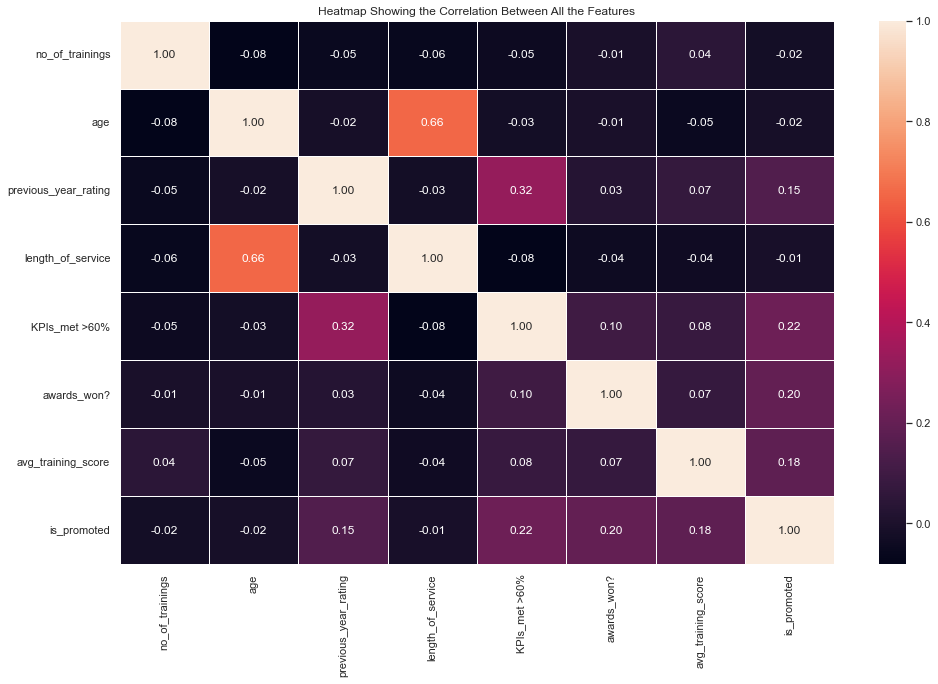

In [206]:
#Heatmap showing the correlation between all variables
heat_train = trainset_copy.drop("employee_id", axis=1)
plt.figure(figsize=(16,10))
sns.heatmap(data=heat_train.corr(), annot=True, fmt=".2f", linewidths=1)
plt.title("Heatmap Showing the Correlation Between All the Features")
plt.show()

## Encoding Some Categorical Variables

In [207]:
#inspect the values in the "region" column
trainset_copy.groupby("is_promoted").get_group(0)["region"].value_counts().head()

region_2     11354
region_22     5694
region_7      4327
region_15     2586
region_13     2418
Name: region, dtype: int64

In [208]:
#replace the values in the "region" column with only numbers
trainset_copy["region"] = trainset_copy["region"].str.split("_", expand=True)[1]

In [209]:
#Inspect the dataset
trainset_copy

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0
1,65141,Operations,22,Bachelor's,m,other,1,30,5.00,4,0,0,60,0
2,7513,Sales & Marketing,19,Bachelor's,m,sourcing,1,34,3.00,7,0,0,50,0
3,2542,Sales & Marketing,23,Bachelor's,m,other,2,39,1.00,10,0,0,50,0
4,48945,Technology,26,Bachelor's,m,other,1,45,3.00,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,14,Bachelor's,m,sourcing,1,48,3.00,17,0,0,78,0
54804,74592,Operations,27,Master's & above,f,other,1,37,2.00,6,0,0,56,0
54805,13918,Analytics,1,Bachelor's,m,other,1,27,5.00,3,1,0,79,0
54806,13614,Sales & Marketing,9,Master's & above,m,sourcing,1,29,1.00,2,0,0,45,0


In [210]:
#encode and delete the original columns
trainset_copy_df = pd.get_dummies(trainset_copy, columns=["department", "education", "gender", "recruitment_channel"], sparse=True, drop_first=True)

In [211]:
#inspect the dataset
trainset_copy_df

,employee_id,region,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >60%,awards_won?,avg_training_score,is_promoted,...,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,7,1,35,5.00,8,1,0,49,0,...,0,0,0,1,0,0,1,0,0,1
1,65141,22,1,30,5.00,4,0,0,60,0,...,1,0,0,0,0,0,0,1,0,0
2,7513,19,1,34,3.00,7,0,0,50,0,...,0,0,0,1,0,0,0,1,0,1
3,2542,23,2,39,1.00,10,0,0,50,0,...,0,0,0,1,0,0,0,1,0,0
4,48945,26,1,45,3.00,2,0,0,73,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,14,1,48,3.00,17,0,0,78,0,...,0,0,0,0,1,0,0,1,0,1
54804,74592,27,1,37,2.00,6,0,0,56,0,...,1,0,0,0,0,0,1,0,0,0
54805,13918,1,1,27,5.00,3,1,0,79,0,...,0,0,0,0,0,0,0,1,0,0
54806,13614,9,1,29,1.00,2,0,0,45,0,...,0,0,0,1,0,0,1,1,0,1


## Feature Selection

In [212]:
#Feature Selection based on the result of the heatmap including the categorical variables
X = trainset_copy_df.drop(["no_of_trainings", "length_of_service", "is_promoted"], axis=1)
y = trainset_copy_df["is_promoted"]

### Undersample Imbalanced Dataset

In [213]:
# Undersample and plot imbalanced dataset with the neighborhood cleaning rule
counter = Counter(y)
print(counter)

# define the undersampling method
undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)

# transform the dataset
X, y = undersample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 50140, 1: 4668})
Counter({0: 38970, 1: 4668})


### Split The Dataset

In [214]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, random_state=1200)

## Inspect Performance of Several Models

In [215]:
#check the best model
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:32<00:00,  3.19s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
DecisionTreeClassifier             0.88               0.70     0.70      0.88   
Perceptron                         0.87               0.70     0.70      0.87   
QuadraticDiscriminantAnalysis      0.90               0.68     0.68      0.89   
XGBClassifier                      0.92               0.68     0.68      0.91   
ExtraTreeClassifier                0.87               0.68     0.68      0.87   
BaggingClassifier                  0.92               0.68     0.68      0.90   
LGBMClassifier                     0.92               0.67     0.67      0.91   
RandomForestClassifier             0.92               0.67     0.67      0.91   
PassiveAggressiveClassifier        0.86               0.67     0.67      0.86   
ExtraTreesClassifier               0.92               0.67     0.67      0.90   
CalibratedClassifierCV      

## Algorithms of some Models

In [216]:
def Model(X_train, y_train, model):

    #scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if model == 1:
        #train the Logistic Regression model
        from sklearn.linear_model import LogisticRegression
        reg = LogisticRegression()
        reg.fit(X_train, y_train)
        print("Logistic Regression DONE...")
    elif model == 2:
        #train the Support Vector Machine model
        from sklearn.svm import SVC
        reg = SVC(kernel = "linear")
        reg.fit(X_train, y_train)
        print("Support Vector Machine DONE...")
    elif model == 3:    
        #train the Decision Tree model
        from sklearn.tree import DecisionTreeClassifier
        reg = DecisionTreeClassifier()
        reg.fit(X_train, y_train)
        print("Decision Tree Classifier DONE...")
    elif model == 4:
        #train the Random Forest model
        from sklearn.ensemble import RandomForestClassifier
        reg = RandomForestClassifier(random_state=0)
        reg.fit(X_train, y_train)
        print("Random Forest Classifier DONE...")
    elif model == 5:
        #train the BaggingClassifier model
        from sklearn.ensemble import BaggingClassifier
        reg = BaggingClassifier()
        reg.fit(X_train, y_train)
        print("BaggingClassifier DONE...")
    return reg

In [217]:
#call the model function and unpack it for Random Forest Classifier
reg_type=int(input("Enter 1 for Logistic Regression: \nEnter 2 for Support Vector Machine: \nEnter 3 for Decision Tree Classifier: \nEnter 4 for Random Forest Classifier: \nEnter 5 for Bagging Classifier:\n\n"))
reg = Model(X_train, y_train, reg_type)

Enter 1 for Logistic Regression: 
Enter 2 for Support Vector Machine: 
Enter 3 for Decision Tree Classifier: 
Enter 4 for Random Forest Classifier: 
Enter 5 for Bagging Classifier:

5
BaggingClassifier DONE...


## Prediction and Performance Evaluation

The Test Accuracy is :			0.913535
----------------------------------------------
Training set score:			99.05%
Test set score:				91.35%
The f1_score:  [0.95277824 0.48824593]
----------------------------------------------


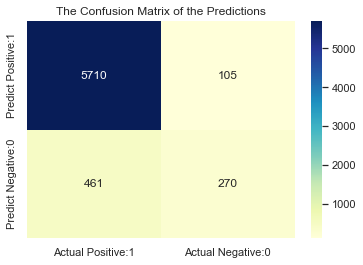

In [218]:
#predict the output of the Validation dataset
print("The Test Accuracy is :\t\t\t{:.6f}".format(accuracy_score(y_test, reg.predict(X_test))))
predcat = reg.predict(X_test)
print("----------------------------------------------")
print(f"Training set score:\t\t\t{reg.score(X_train, y_train)*100:.4}%")
print(f"Test set score:\t\t\t\t{reg.score(X_test, y_test)*100:.4}%")
print(f"The f1_score: ", f1_score(y_test, reg.predict(X_test), average=None))

print("----------------------------------------------")

#The Confusion Matrix of the Predictions
cm = confusion_matrix(y_test, reg.predict(X_test), labels=[0, 1])
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title("The Confusion Matrix of the Predictions")
plt.savefig("third_confusion.png")
plt.show()

In [219]:
#The Classification Report
print("The Classification Report")
print(classification_report(y_test, reg.predict(X_test)))

The Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      5815
           1       0.72      0.37      0.49       731

    accuracy                           0.91      6546
   macro avg       0.82      0.68      0.72      6546
weighted avg       0.90      0.91      0.90      6546



In [220]:
#Trying out different models are not any better
#So we stick to the first CATBOOST model